In [13]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap

import time
import importlib
from os.path import isfile
from sklearn.model_selection import train_test_split
import torchvision.transforms as tfs
from sklearn.metrics import accuracy_score
from scipy.stats import iqr as IQR
from torch.nn.functional import pdist

from sklearn.neighbors import KNeighborsClassifier

# import utils file
spec = importlib.util.spec_from_file_location('utils', 'utils.py')
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

In [14]:
def get_train_test_groups(section, morpho_feats):
    bodyId_type_Nmito = []
    mito_feats = np.array([ [] for _ in range(len(morpho_feats)) ]).T
    bodyIds = np.array([])

    is_symmetry = [ 'symmetry' in this_feat for this_feat in morpho_feats ]
    sym_feats = np.array(morpho_feats)[is_symmetry]
    
    for neuron_type in utils.analyze_neurons:
        for bodyId in utils.neuron_quality_np[utils.neuron_quality_np[:,1] == neuron_type,0]:
            mito_file = f'saved_mito_df/{neuron_type}_{bodyId}_mito_df.csv'
            if isfile(mito_file):
                # this neuron has a saved mitochondria csv file
                mito_df = pd.read_csv(mito_file)
                is_in_section = np.all([mito_df['class'].to_numpy() == utils.node_class_dict[section],
                                        np.all(mito_df[sym_feats].to_numpy() > 0, axis=1),
                                        np.all(mito_df[sym_feats].to_numpy() < 1, axis=1)],axis=0)
                if np.any(is_in_section):
                    bodyId_type_Nmito.append( [bodyId, neuron_type, np.sum(is_in_section)] )
                    
                    this_feats = mito_df[np.array(morpho_feats)[:-1]].to_numpy()[is_in_section]
                    
                    mito_radii = ((mito_df['size'].to_numpy() * 3) / (np.pi * 4)) ** (1/3)
                    SBI = np.arctanh(4 * np.pi * (mito_radii**2) / mito_df['mito SA'].to_numpy())[is_in_section]
                    
                    this_feats = np.concatenate([this_feats, SBI[:,np.newaxis]], axis=1)
                    for i_feat in np.where(is_symmetry)[0]:
                        this_feats[:,i_feat] = np.arctanh(this_feats[:,i_feat])
                    mito_feats = np.append(mito_feats, this_feats,axis=0)
                    bodyIds = np.append( bodyIds, np.ones((len(this_feats),1)) * bodyId)
    
    bodyId_type_Nmito = np.array(bodyId_type_Nmito, dtype=object)
    bodyIds_train = [ train_test_split(bodyId_type_Nmito[bodyId_type_Nmito[:,1] == neuron_type, 0], test_size = 0.2)[0] for neuron_type in utils.analyze_neurons ]
    
    
    for is_train in [0,1]:
        bool_points = np.isin(bodyIds, np.concatenate(bodyIds_train,axis=0)) == is_train
        mean_vals = np.mean(mito_feats[bool_points], axis=0)
        std_vals = np.std(mito_feats[bool_points], axis=0)
        mito_feats[bool_points] = ( mito_feats[bool_points] - mean_vals ) / std_vals

    return bodyIds_train, bodyIds, mito_feats, bodyId_type_Nmito

In [15]:
class ConvNet(nn.Module):
    def __init__(self, device, in_channels, channel_width):
        super().__init__()

        self.net_conv_params = [{'layer_type': 'Conv1d', 'in_channels': in_channels, 'out_channels': 10, 'kernel_size': 11, 'stride': 1},
                                {'layer_type': 'MaxPool1d', 'kernel_size': 11, 'stride': 1}]
        
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.layers_dim = [channel_width]

        #p = 0.2
        #self.drop = nn.Dropout(p=p)
        
        for i_layer in range(len(self.net_conv_params)):
            kernel_size = self.net_conv_params[i_layer][f'kernel_size']
            padding = int(kernel_size/2)
            stride = self.net_conv_params[i_layer][f'stride']
            if self.net_conv_params[i_layer]['layer_type'] == 'Conv1d':
                in_channels = self.net_conv_params[i_layer][f'in_channels']
                out_channels = self.net_conv_params[i_layer][f'out_channels']
                self.conv_layers.append( nn.Conv1d(kernel_size=kernel_size, stride=stride, in_channels = in_channels, out_channels=out_channels, padding=padding).to(device) )
                self.bn_layers.append(nn.BatchNorm1d(out_channels))
            elif self.net_conv_params[i_layer]['layer_type'] == 'MaxPool1d':
                self.conv_layers.append( nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding).to(device) )
            
            self.layers_dim.append( int( ( self.layers_dim[-1] - kernel_size + 2*padding) / stride) + 1 )
        

        self.lin_dim = self.layers_dim[-1] * out_channels
        self.fc1 = nn.Linear(self.lin_dim, 100)
        self.fc2 = nn.Linear(100, 25)
        self.fc3 = nn.Linear(25, 2)
    def forward(self, x):
        residual = x
        # need to do zero padding first
        for i_layer in range(len(self.net_conv_params)):
            #print(x.shape, self.layers_dim[i_layer], self.layers_dim[i_layer+1])
            #print( self.conv_layers[i_layer] )
            x = self.conv_layers[i_layer](x)
            if self.net_conv_params[i_layer]['layer_type'] == 'Conv1d':
                # just did a convolutional layer, so do a nonlinearity
                x = F.relu(x)
                x = self.bn_layers[i_layer](x)
                #x = self.drop(x)
                
        residual = F.pad(residual, (0, 0, 0, x.size(1) - residual.size(1)))
        x += residual
        #x = F.pad( x, pad = padding, value = 0)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        #x = self.drop(x)
        x = F.relu(self.fc2(x))
        #x = self.drop(x)
        x = F.sigmoid(self.fc3(x))
        return x

In [16]:
device = 'cpu'
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

Using device:  cpu


In [17]:
def my_loss(y_pred, train_ids):
    T = 0.2 # self.temperature
    #sims = torch.exp(- pdist( y_pred ) / T)
    #sim_matrix = torch.exp(torch.matmul(y_pred_L2, y_pred_L2.T) / T)
    train_id_mat = train_ids[:,np.newaxis].repeat(1,len(train_ids))
    upper_tri_bool = torch.triu(torch.ones(train_id_mat.shape, dtype=bool), diagonal = 1)

    y_pred_L2 = torch.nn.functional.normalize(input=y_pred, p=2, dim=1)
    cos_dists = torch.matmul(y_pred_L2, y_pred_L2.T)
    
    all_dists = cos_dists[upper_tri_bool] + pdist(y_pred)
    sims = torch.exp(-all_dists / T)

    
    loss = None
    for id in torch.unique(train_ids):
        positive_mask = ((train_id_mat == train_id_mat.T) & (train_id_mat == id))[ upper_tri_bool ]
        neg_mask = ((train_id_mat != train_id_mat.T) & ((train_id_mat == id) | (train_id_mat.T == id)))[upper_tri_bool]
        if loss is None:
            loss = -torch.log( torch.mean(sims[positive_mask]) / ( torch.mean(sims[positive_mask]) + torch.mean(sims[neg_mask]) ) )
        else:
            loss += -torch.log( torch.mean(sims[positive_mask]) / ( torch.mean(sims[positive_mask]) + torch.mean(sims[neg_mask]) ) )
    return loss

In [18]:
morpho_feats = []
morpho_feats.append( 'size' )
morpho_feats.append( 'mito SA' )
morpho_feats.append( 'mito CA' )
morpho_feats.append( 'convex hull compactness' )
morpho_feats.append( 'PC1 Length' )
morpho_feats.append( 'PC1 inertia moment' )
morpho_feats.append( 'PC1 symmetry' )
morpho_feats.append( 'PC1 CA' )
morpho_feats.append( 'PC1 Circum' )

morpho_feats.append( 'PC2 Length' )
#morpho_feats.append( 'PC2 inertia moment' )
morpho_feats.append( 'PC2 symmetry' )
morpho_feats.append( 'PC2 CA' )
morpho_feats.append( 'PC2 Circum' )

morpho_feats.append( 'PC3 Length' )
#morpho_feats.append( 'PC3 inertia moment' )
morpho_feats.append( 'PC3 symmetry' )
morpho_feats.append( 'PC3 CA' )
morpho_feats.append( 'PC3 Circum' )

morpho_feats.append( 'mito diameter' )
morpho_feats.append( 'length along skeleton' )
morpho_feats.append( 'SBI' )

epochs=20000
nbatches = 5
frac_replace = 0.2 # fraction of mitochondria in bodyId to replace with another neuron in the same neuron type
section = 'axon'

bodyIds_train, bodyIds, mito_feats, bodyId_type_Nmito = get_train_test_groups(section, morpho_feats)

h = np.mean([2 * IQR(this_list) * ( len(this_list)**(-1/3) ) for this_list in mito_feats.T ])
bins = np.arange(-5, 5 + h/2, h)

test_bodyIds = bodyIds[ ~np.isin(bodyIds, np.concatenate(bodyIds_train,axis=0)) ]
test_x = []
test_actual = []
for bodyId in test_bodyIds:
    this_type, N = bodyId_type_Nmito[ bodyId_type_Nmito[:,0] == bodyId, [1,2]]
    i_mitos = np.where(bodyIds == bodyId)[0]
    # get histogram of i_mitos
    test_x.append( [ np.histogram(this_vals, bins=bins)[0] / len(i_mitos)  for this_vals in mito_feats[i_mitos].T ] )
    test_actual.append( np.where( np.array(utils.analyze_neurons) == this_type )[0][0] )
test_actual = torch.LongTensor(test_actual)
test_x = torch.Tensor(np.array(test_x))

i_mitos_type = [ np.where( np.isin( bodyIds, bodyId_type_Nmito[ bodyId_type_Nmito[:,1] == this_type, 0 ] )  )[0] for this_type in utils.analyze_neurons ]
sample_weights = torch.Tensor([ 1/ np.sum(bodyId_type_Nmito[:,1] == neuron_type) for neuron_type in utils.analyze_neurons ])

model = ConvNet(device, in_channels = len(morpho_feats), channel_width = len(bins)-1)
#criterion = nn.CrossEntropyLoss(weight = sample_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay = 1e-6)

In [19]:
train_loss_list, train_acc_list, test_accs = [], [], []
best_test_acc = 0
patience = 1000
count = 0

t0 = time.time()
for i in range(epochs):
    if (i % 1000) == 0:
        print(f'On epoch {i} of {epochs}  |  {np.round((time.time()-t0)/60,decimals=2)} minutes')
    
    train_loss_epoch = 0
    all_latent_coords, all_true = np.array([ [], [] ]).T, []
    
    all_batch_bodyIds = [ utils.get_batches(bodyIds_train[i_type], nbatches) for i_type in range(len(utils.analyze_neurons)) ]
    model.train()
    
    for i_batch in range(nbatches):
        #print(i_batch, end = ', ')
        batch_bodyIds = np.concatenate([ all_batch_bodyIds[i_type][i_batch] for i_type in range(len(utils.analyze_neurons)) ], axis=0)
        #train_ids = torch.LongTensor(np.concatenate([ np.ones(len(all_batch_bodyIds[i_type][i_batch]))*i_type for i_type in range(len(utils.analyze_neurons)) ], axis=0))
        train_ids, batch_x = [], []
        
        for bodyId in batch_bodyIds:
            this_type, N = bodyId_type_Nmito[ bodyId_type_Nmito[:,0] == bodyId, [1,2]]
            n_replace = int( N * frac_replace)
            i_mitos = np.where(bodyIds == bodyId)[0]
            if n_replace > 0:
                np.random.shuffle(i_mitos)
        
                # all mitos in this neuron type
                i_this_type = np.where( np.array(utils.analyze_neurons) == this_type )[0][0]
                i_mitos = np.append( i_mitos[:-n_replace], np.random.choice( i_mitos_type[i_this_type] , size = n_replace, replace = False) )
            # get histogram of i_mitos
            batch_x.append( [ np.histogram(this_vals, bins=bins)[0] / len(i_mitos)  for this_vals in mito_feats[i_mitos].T ] )
            train_ids.append( np.where( np.array(utils.analyze_neurons) == this_type )[0][0] )
        batch_x = torch.Tensor( np.array(batch_x) )
        train_ids = torch.LongTensor(train_ids)
        y_pred = model.forward(batch_x)

        loss = my_loss(y_pred, train_ids)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss_epoch += loss.detach().numpy() * len(train_ids)
        all_latent_coords = np.append(all_latent_coords, y_pred.detach().numpy(), axis=0)

        all_true.append(train_ids)
    train_loss_list.append(train_loss_epoch)
    all_true = torch.cat(all_true,dim=0)
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(all_latent_coords, all_true.numpy())
    acc = neigh.score(all_latent_coords, all_true.numpy())
    train_acc_list.append(acc)

    model.eval()
    with torch.no_grad():
        y_pred = model.forward(test_x)
        test_acc = neigh.score(y_pred.detach().numpy(), test_actual.numpy())
        test_accs.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            count = 0
        else:
            count += 1
            if count >= patience:
                print(f'Early stopping at epoch {i} with test accuracy {test_acc:.4f}')
                break



# 43% at 1k
# 65.70 at 3k?

On epoch 0 of 20000  |  0.0 minutes
On epoch 1000 of 20000  |  17.45 minutes
On epoch 2000 of 20000  |  35.11 minutes
Early stopping at epoch 2304 with test accuracy 0.4653


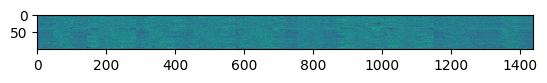

In [20]:
plt.imshow(model.fc1.weight.detach().numpy())

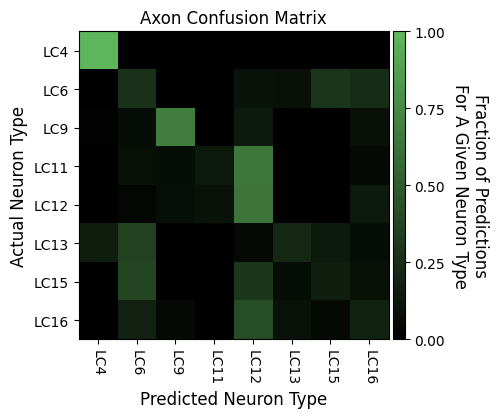

In [21]:
test_preds_np = neigh.predict(y_pred.detach().numpy())
test_actual_np = test_actual.numpy()

heat_matrix = np.zeros( (len(utils.analyze_neurons),len(utils.analyze_neurons)) )
for i_type, neuron_type in enumerate(utils.analyze_neurons):
    for j_i_type, j_neuron_type in enumerate(utils.analyze_neurons):
        heat_matrix[i_type, j_i_type] = np.sum( np.all([test_preds_np==j_i_type, test_actual_np == i_type],axis=0) )
heat_matrix = heat_matrix / np.sum(heat_matrix,axis=1)[:,np.newaxis]

fig = plt.figure( figsize=(4,4) )
fontsize=12

if section == 'All Compartments':
    im = plt.imshow(heat_matrix, vmin=0, vmax=1, aspect='auto')#, cmap = 'hot')
else:
    newcolors = np.linspace(0,1,1000)[:,np.newaxis] * np.append(utils.section_colors[section], 1)
    newcolors[:,-1] = 1
    newcmp = ListedColormap(newcolors)
    
    im = plt.imshow(heat_matrix, vmin=0, vmax=1, aspect='auto', cmap = newcmp)
plt.yticks(ticks = np.arange(len(utils.analyze_neurons)), labels = utils.analyze_neurons, fontsize=10)  # remove axis labels
plt.xticks(ticks = np.arange(len(utils.analyze_neurons)), labels = utils.analyze_neurons, fontsize=10, rotation=270)  # remove axis labels
plt.xlabel('Predicted Neuron Type', fontsize=fontsize)
plt.ylabel('Actual Neuron Type', fontsize=fontsize)
plt.title(f'{section.title()} Confusion Matrix', fontsize=fontsize)

axcolor = fig.add_axes([0.91, 0.11, 0.03, 0.77])
cbar = plt.colorbar(im, cax=axcolor, ticks= np.arange(0,1.01, 0.25))#, label = 'Fraction of Neurons in Actual Neuron Type')
cbar.set_label('Fraction of Predictions\nFor A Given Neuron Type', fontsize=fontsize, rotation = 270, ha = 'center', va = 'bottom')
#plt.savefig(home_dir + f'/saved_figures/mito_morphology_embedding/CellTypePrediction_ConfusionMatrix_{section}.svg', transparent=True, bbox_inches='tight')
plt.show()

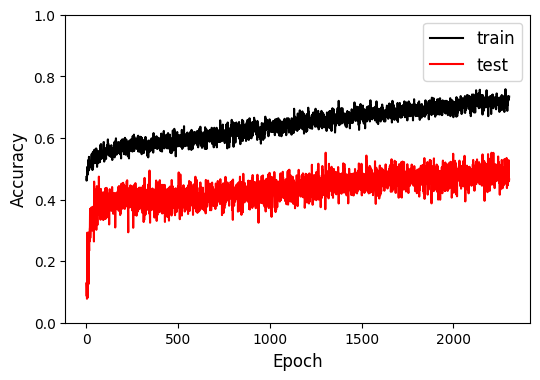

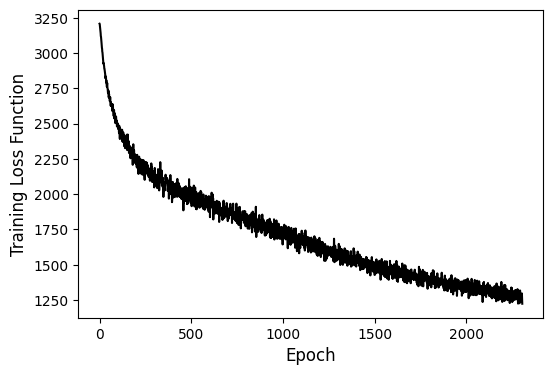

In [22]:
# plot training and test accuracies
fig = plt.figure(figsize=(6,4))
fontsize=12
plt.plot(np.arange(len(train_acc_list)), train_acc_list, color = 'k', label = 'train')
plt.plot(np.arange(len(test_accs)), test_accs, color = 'r', label = 'test')
plt.ylabel('Accuracy', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylim([0,1])
plt.show()

fig = plt.figure(figsize=(6,4))
fontsize=12
plt.plot(np.arange(len(train_loss_list)), train_loss_list, color = 'k')
plt.ylabel('Training Loss Function', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.show()

In [23]:
print(max(test_accs))

0.5520304568527918


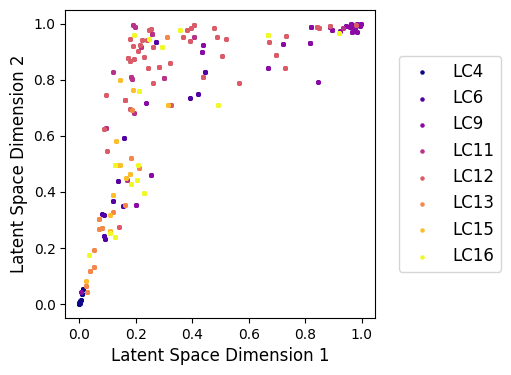

In [24]:
from matplotlib import pyplot as plt

# plt.scatter(y_pred[:,0], y_pred[:,1], s = 5)


fig,ax = plt.subplots(figsize=(4,4))
fontsize=12
for label in np.unique(test_actual):
    color = plt.colormaps['plasma'](np.linspace(0,1,np.max(np.array(test_actual))+1))[label]

    ax.scatter(y_pred[test_actual==label,0],y_pred[test_actual == label,1], s = 5, color = color, label = utils.analyze_neurons[label])

ax.set_xlabel('Latent Space Dimension 1', fontsize=fontsize)
ax.set_ylabel('Latent Space Dimension 2', fontsize=fontsize)
ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left', fontsize=fontsize)
plt.show()